# Load data dan EDA

In [163]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [164]:
df = pd.read_csv(r'..\data\tryout_data.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3252 entries, 0 to 3251
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   participant_no    3252 non-null   int64 
 1   name              3252 non-null   object
 2   pu                3252 non-null   object
 3   ppu               3252 non-null   object
 4   kmbm              3252 non-null   object
 5   pk                3252 non-null   object
 6   lit_ind           3252 non-null   object
 7   lit_ing           3252 non-null   object
 8   pm                3252 non-null   object
 9   total             3252 non-null   object
 10  status_kelulusan  3252 non-null   object
 11  timestamp         3252 non-null   object
dtypes: int64(1), object(11)
memory usage: 305.0+ KB


Output ini menunjukkan struktur DataFrame setelah proses ekstraksi data dari website (sc : "https://hasilto.bimbelssc.com/storage/ponorogo/intipa/data/TO_SNBT_JANUARI.html"). DataFrame terdiri dari 3.252 baris (entries) dan 12 kolom.

Beberapa poin penting dari output:
- Kolom participant_no bertipe int64, sementara kolom lainnya masih bertipe object, termasuk kolom-kolom nilai ujian seperti pu, ppu, kmbm, dll. Ini menunjukkan bahwa kolom-kolom nilai perlu dikonversi ke tipe numerik agar dapat dianalisis secara statistik.
- Tidak ada nilai null (Non-Null Count = 3.252 untuk semua kolom), artinya tidak terdapat data yang hilang secara eksplisit dalam dataset.

# Preparation data

## Pra-pemrosesan Data
Tahap ini melakukan pembersihan atau transformasi data. Misalnya:
- Menghapus kolom yang tidak relevan
- Mengisi nilai kosong
- Mengubah tipe data
- Normalisasi atau standarisasi nilai

### Menghapus kolom yang tidak relevan
Pada tahap ini kolom "participant_no", "name", "status_kelulusan", dan "timestamp" akan dihilangkan karena tidak dibutuhkan dalam clustering

In [165]:
df = df.drop(columns=['participant_no', 'name', 'status_kelulusan', 'timestamp'])

df.tail(5)

,pu,ppu,kmbm,pk,lit_ind,lit_ing,pm,total
3247,"22,87",X,X,X,X,X,X,"3,27"
3248,X,X,X,X,"12,39",X,"0,00","1,77"
3249,X,X,X,X,"12,39",X,X,"1,77"
3250,X,X,X,X,"12,39",X,X,"1,77"
3251,X,X,X,X,"12,39",X,X,"1,77"


### Handle missing value dan duplicate data
Tahap ini mengganti nilai nol yang ditandai dengan "X" menjadi 0, kemudian menghapus spasi dan mengganti tanda koma menjadi titik. Selanjutnya mengubah tipe data menjadi float agar dapat dilakukan feature engineering.

In [166]:
# 1. Ganti 'X' dengan '0'
df = df.replace('X', 0)

# 2. Bersihkan data: hapus spasi & ganti koma dengan titik
df = df.applymap(lambda x: str(x).replace(' ', '').replace(',', '.'))

# 3. Konversi ke float per kolom (lebih aman)
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')


C:\Users\hp\AppData\Local\Temp\ipykernel_14592\3432355070.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: str(x).replace(' ', '').replace(',', '.'))


memeriksa kembali apakah tipe data untuk setiap kolom sudah berubah menjadi float

In [167]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3252 entries, 0 to 3251
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   pu       3234 non-null   float64
 1   ppu      3250 non-null   float64
 2   kmbm     3252 non-null   float64
 3   pk       3252 non-null   float64
 4   lit_ind  3252 non-null   float64
 5   lit_ing  3252 non-null   float64
 6   pm       3252 non-null   float64
 7   total    3252 non-null   float64
dtypes: float64(8)
memory usage: 203.4 KB


mendeteksi banyaknya missing value untuk setiap kolom

In [168]:
df.isnull().sum()

pu         18
ppu         2
kmbm        0
pk          0
lit_ind     0
lit_ing     0
pm          0
total       0
dtype: int64

mengisi missing value dengan nilai rata-rata karena metode ini mempertahankan distribusi data dan tidak mempengaruhi ukuran sampel secara signifikan. Selanjutnya menghapus data yang terduplikasi.

In [169]:
df = df.fillna(df.mean())

df = df.drop_duplicates()

### Feature engineering
Akan dibuat kolom baru yang berisi nilai rata-rata, simpangan baku, total, terkecil dan terbesar pada setiap baris data untuk disesuaikan pada data utama.

In [170]:
df['Mean'] = df[['pu', 'ppu', 'kmbm', 'pk', 'lit_ind', 'lit_ing', 'pm']].mean(axis=1)
df['Sbaku'] = df[['pu', 'ppu', 'kmbm', 'pk', 'lit_ind', 'lit_ing', 'pm']].std(axis=1)
df['Min'] = df[['pu', 'ppu', 'kmbm', 'pk', 'lit_ind', 'lit_ing', 'pm']].min(axis=1)
df['Max'] = df[['pu', 'ppu', 'kmbm', 'pk', 'lit_ind', 'lit_ing', 'pm']].max(axis=1)
df['TOTAL'] = df[['pu', 'ppu', 'kmbm', 'pk', 'lit_ind', 'lit_ing', 'pm']].sum(axis=1)

### Feature selection dan normalisasi data
Dipilih kolom "Mean" dan "TOTAL" dari proses feature selection karena keduanya merepresentasikan ringkasan performa peserta secara menyeluruh dan memiliki kontribusi signifikan terhadap pemisahan klaster. Normalisasi dilakukan dengan metode MinMax karena metode ini mengubah skala data ke rentang 0–1 tanpa mengubah distribusi bentuk aslinya, sehingga cocok untuk algoritma berbasis jarak seperti KMeans.

In [171]:
from sklearn.preprocessing import MinMaxScaler

dataFiks = df[['Mean', 'TOTAL']]

scaler = MinMaxScaler()
dataFiks = scaler.fit_transform(dataFiks) 

# Clustering

Akan dilakukan clustering menggunakan algoritma K-Means karena algoritma ini efektif untuk mengelompokkan data berdasarkan kemiripan fitur dan relatif mudah diimplementasikan. Namun, sebelumnya dilakukan penentuan jumlah cluster optimal dengan metode elbow untuk mencari banyak cluster yang paling sesuai.

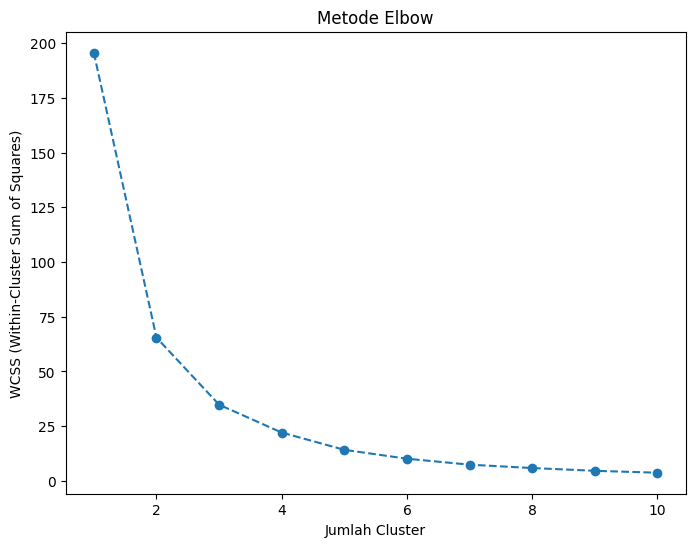

In [172]:
from sklearn.cluster import KMeans

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(dataFiks)
    wcss.append(kmeans.inertia_)

# Visualisasi elbow method
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title("Metode Elbow")
plt.xlabel("Jumlah Cluster")
plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
plt.show()

Dilihat pada grafik elbow di atas, titik siku pada grafik tersebut berada pada angka 3 sehingga dapat disimpulkan, jumlah cluster optimal adalah 3.

In [173]:
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
cluster = kmeans.fit_predict(dataFiks)

In [174]:
silhouette_avg = silhouette_score(dataFiks, cluster)
print(f"Silhouette Score yang didapat: {silhouette_avg:.3f}")

Silhouette Score yang didapat: 0.531


Hasil dari clustering diukur dengan Silhouette Score karena metrik ini mengukur seberapa baik data dalam satu cluster serupa satu sama lain dan terpisah dari cluster lain, memberikan indikasi kualitas clustering. Didapatkan nilai silhouette sebesar 0.531 yang mana ini sudah cukup baik, karena nilai di atas 0.5 menunjukkan pemisahan cluster yang cukup jelas, meskipun masih ada ruang untuk peningkatan.

# Visualisasi hasil cluster

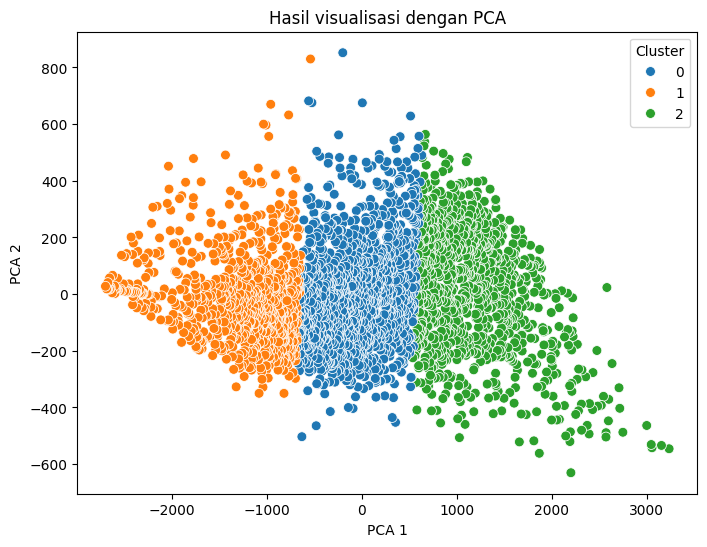

In [175]:
from sklearn.decomposition import PCA

df['Cluster'] = cluster

pca = PCA(n_components=2)
data_2d = pca.fit_transform(df)

df_pca = pd.DataFrame(data_2d, columns=['PCA1', 'PCA2'])
df_pca['Cluster'] = cluster

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='PCA1', y='PCA2', hue='Cluster', data=df_pca, palette='tab10', s=50
)
plt.title("Hasil visualisasi dengan PCA")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster")
plt.show()

Visualisasi di atas menunjukkan hasil clustering data menggunakan algoritma K-Means setelah dilakukan reduksi dimensi dengan Principal Component Analysis (PCA). PCA digunakan untuk mengurangi jumlah dimensi data ke dalam dua komponen utama (PC1 dan PC2) agar dapat divisualisasikan dalam plot 2D. Titik-titik pada scatter plot mewakili data yang telah dikelompokkan menjadi tiga cluster, yang masing-masing ditandai dengan warna berbeda (biru, oranye, dan hijau). Pemisahan cluster tampak cukup jelas, menunjukkan bahwa metode ini berhasil mengidentifikasi pola dalam data.

# Interpretasi hasil

In [176]:
cluster0 = df[df['Cluster'] == 0]
cluster0[['Mean', 'Sbaku', 'Min', 'Max']].describe()

,Mean,Sbaku,Min,Max
count,1303.000000,1303.000000,1303.000000,1303.000000
mean,341.108407,166.040999,125.927682,583.823922
std,44.322341,53.431203,68.538981,116.864602
min,262.362857,45.226428,0.000000,331.620000
25%,303.432857,127.927796,86.670000,494.760000
50%,341.094286,161.263849,133.710000,572.330000
75%,378.464286,198.114678,178.550000,657.320000
max,418.955714,381.897656,325.620000,952.830000


In [177]:
cluster1 = df[df['Cluster'] == 1]
cluster1[['Mean', 'Sbaku', 'Min', 'Max']].describe()

,Mean,Sbaku,Min,Max
count,905.000000,905.000000,905.000000,905.000000
mean,182.491762,119.613546,46.716442,368.114586
std,65.112782,48.111718,54.338256,112.159155
min,1.770000,4.682980,0.000000,12.390000
25%,154.018571,87.602637,0.000000,299.550000
50%,200.277143,113.325892,19.100000,361.500000
75%,232.498571,146.345784,92.860000,429.630000
max,262.212857,372.705630,219.080000,909.850000


In [178]:
cluster2 = df[df['Cluster'] == 2]
cluster2[['Mean', 'Sbaku', 'Min', 'Max']].describe()

,Mean,Sbaku,Min,Max
count,1039.000000,1039.000000,1039.000000,1039.000000
mean,496.163432,204.843099,215.773619,789.368527
std,61.505967,49.514478,97.536313,97.987594
min,419.178571,48.155468,0.000000,470.100000
25%,447.640000,169.874086,144.240000,725.810000
50%,484.254286,205.892084,209.770000,794.550000
75%,530.210000,239.847044,278.970000,856.390000
max,771.552857,347.851928,629.570000,1000.000000


Hasil di atas menunjukkan ringkasan statistik deskriptif untuk tiga cluster yang dihasilkan dari proses clustering, berdasarkan kolom 'Mean' dan 'Sbaku' (standar deviasi), serta nilai minimum ('Min') dan maksimum ('Max'). Data ini dihasilkan dari perintah .describe() pada DataFrame yang telah dikelompokkan berdasarkan kolom 'Cluster' dengan nilai 0, 1, dan 2.

- Cluster 0: Berisi 1303 data dengan rata-rata 'Mean' 341.10 dan standar deviasi 44.32, dengan rentang nilai dari 262.36 hingga 418.55. Ini menunjukkan variasi yang cukup besar dalam data atau dapat diartikan populasi yang mendapatkan nilai sedang.
- Cluster 1: Berisi 905 data dengan rata-rata 'Mean' 182.41 dan standar deviasi 65.17, dengan rentang nilai dari 0.00 hingga 262.12, menunjukkan distribusi yang lebih luas dan termasuk nilai nol atau dapat diartikan populasi yang mendapatkan nilai rendah.
- Cluster 2: Berisi 1039 data dengan rata-rata 'Mean' 496.16 dan standar deviasi 61.50, dengan rentang nilai dari 419.77 hingga 775.53, mengindikasikan cluster dengan nilai tertinggi atau dapat diartikan populasi yang mendapatkan nilai tinggi.
Ringkasan ini mencakup kuartil (25%, 50%, 75%) yang memberikan gambaran distribusi data dalam setiap cluster, membantu dalam memahami karakteristik dan pemisahan antar cluster.

# Save model

In [179]:
import joblib

joblib.dump(kmeans, 'model_clustering.pkl')


['model_clustering.pkl']